比赛的网址是 https://www.kaggle.com/c/cifar-10

**注意**
+ 这里其实没有使用迁移学习，使用的resnet18完全只有网络结构，没有用到pretrained的权重
+ 所以这里其实是从头开始训练的
+ 可以试一下迁移训练，效果肯定不会差的。

# 1. 导入基本包

In [2]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
import d2l_torch as d2l

+ 关于`shutil`，网上大部分介绍是一个高阶的文件操作库，捯饬文件用的。有兴趣的可以看看文档，[这里](https://docs.python.org/zh-cn/3/library/shutil.html)
+ 关于`torchvision`，这个库更新很慢，但是很稳定，但是没有很多新的内容，有很多个人维护的新库，功能可能会更丰富一些，所以做实验的时候也不用完全局限在torchvision上。比如，也可以考虑使用mmCV系列的库
    + mmCV也是基于torch写的库，github地址：<https://github.com/open-mmlab/mmcv/blob/master/README_zh-CN.md>

>+ MIM: MIM 是 OpenMMlab 项目、算法、模型的统一入口
+MMClassification: OpenMMLab 图像分类工具箱
+MMDetection: OpenMMLab 目标检测工具箱
+MMDetection3D: OpenMMLab 新一代通用 3D 目标检测平台
+MMRotate: OpenMMLab 旋转框检测工具箱与测试基准
+MMSegmentation: OpenMMLab 语义分割工具箱
   
   + 另外，还有FAR的Detectron，<https://github.com/facebookresearch/Detectron>
   + 以及图森未来维护的一个`SimpleDet`
+ 参考：[目标检测三大开源神器：Detectron2/mmDetection/SimpleDet](https://zhuanlan.zhihu.com/p/96931265目标检测三大开源神器：Detectron2/mmDetection/SimpleDet)

# 2. 下载自制的简单的demo数据

In [10]:
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

demo = True # 控制下载这里demo的小数据集，还是使用kaggle上下载解压的完整数据集

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10/' # 可以把kaggle下载的完整数据放在这里

+ 因为如果使用kaggle上的数据集，下起来和解压都很费劲，所以这里使用自己再抽取的一个更小的数据集
+ 对原始的kaggle上的cifar10数据集
    + 每个类在原先的训练集中，取前1k的训练图像作为训练集，
    + 在原先的测试集中，随机挑选5个测试图像作为测试集（所有类别一共5个。。。）
    + 所以测试集就小很多咧

# 3. 读取label

In [11]:
def read_csv_labels(fname):
    """读取 `fname` 来给标签字典返回一个文件名。"""
    with open(fname, 'r') as f:
        lines = f.readlines()[1:]  # 第一行是标题行，id和label
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv')) 
print(f"{[labels[str(i)] for i in range(930,950)]}")

['frog', 'deer', 'frog', 'dog', 'bird', 'deer', 'frog', 'automobile', 'frog', 'airplane', 'deer', 'airplane', 'cat', 'automobile', 'ship', 'dog', 'deer', 'deer', 'automobile', 'horse']


+ 训练集的标签位于：`trainLabels.csv`文件中
+ 打开文件看看，其实第一列就是图像序号，第二列就是该图像的标签（类别）
+ 其实完全没必要用上面这个方式读取，直接用pandas的`read_csv`来读，不是更简单吗。。。

In [4]:
alllabels=[labels[str(i)] for i in range(1,1000)]

In [5]:
set(alllabels)

{'airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck'}

所以整体确实是10类

# 4. 重新整理训练、验证和测试集(这里指定了batch_size)

In [12]:
def copyfile(filename, target_dir):
    """将文件复制到目标目录。"""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

def reorg_train_valid(data_dir, labels, valid_ratio):
    n = collections.Counter(labels.values()).most_common()[-1][1] # 找到数据集中图像数量最少的那个类别的个数
    n_valid_per_label = max(1, math.floor(n * valid_ratio)) # 以最小训练集的图像类别，作为抽取验证集的基础
    label_count = {} # 统计验证集中每个label的数量
    for train_file in os.listdir(os.path.join(data_dir, 'train')): # 对训练集中所有的图像
        label = labels[train_file.split('.')[0]]  # 用id来找到对应的label，文件名就是id.png
        fname = os.path.join(data_dir, 'train', train_file)  # 拿到每个图像的完整路径
        copyfile(
            fname,
            os.path.join(data_dir, 'train_valid_test', 'train_valid', label)) # 新建的文件夹的名称，挺长的。
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(
                fname,
                os.path.join(data_dir, 'train_valid_test', 'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(
                fname,
                os.path.join(data_dir, 'train_valid_test', 'train', label))
    return n_valid_per_label

上面代码的功能很简单
+ 为了把图像数据集整理成可以使用`torchvision.dataloader`读取的形式，
    + 这个函数详见：<https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader>
    + 或者也可以参考：<https://pytorch.org/tutorials/beginner/basics/data_tutorial.html>
+ 需要把每个类的图像放在一个，以类名命名的文件夹里
+ 但是上面代码其实新建了三个文件夹：
    + `train_valid`，训练集和验证集在一起
    + `valid`，只有验证集（超过规定的`n_valid_per_label`数量之后，就放到训练集去）
    + `train`，只有训练集
+ 另外，注意：`train_valid_test`文件夹和下载下来的cifar-tiny中的`train`文件夹是同级的
    + 因为`train`文件夹下直接就是图像，因此还不如自己新建一个`train_valid_test`文件夹，用来更清晰的分类，整理图像
    + 这里其实可以认为，`train_valid_test`中的`train`和`valid`是一个一折交叉验证，demo做五折的话比较耗时，其实加个随机数种子也可以很快搞成5折。
+ 因此，整体的步骤是：
    + 先在`train_valid_test`中的`train`上训练一边模型，
    + 用`train_valid_test`中的`valid`做验证。
    + 然后再在`train_valid_test`中的`train_valid`上再完整训练一边

In [7]:
collections.Counter(labels.values()).most_common()

[('automobile', 112),
 ('frog', 107),
 ('truck', 103),
 ('horse', 102),
 ('airplane', 102),
 ('deer', 99),
 ('bird', 99),
 ('ship', 99),
 ('cat', 92),
 ('dog', 85)]

In [13]:
def reorg_test(data_dir):
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(
            os.path.join(data_dir, 'test', test_file),
            os.path.join(data_dir, 'train_valid_test', 'test', 'unknown'))

+ 同时，也把原始的cifar10-tiny中的`test`文件夹下的图像，放到`'train_valid_test'`文件夹中
+ 之后整个数据集就基于`'train_valid_test'`这个作为根目录来进行了

In [14]:
def reorg_cifar10_data(data_dir,valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv')) 
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

In [15]:
batch_size=32 if demo else 128
valid_ratio=0.1 #85X0.1=8，所以验证集应该是8张
reorg_cifar10_data(data_dir,valid_ratio)

+ 一开始上面代码在`reorg_train_valid`函数的`label = labels[train_file.split('.')[0]] `这句报错
+ 看了一下文件夹，很奇怪，应该全是图片，但是竟然还有一个`.ipynb_checkpoints`的文件夹，删了这个文件夹就好了。。诡异
+ 运行完之后，就可以看到类似这样的文件结构:
```bash
|-- kaggle_cifar10_tiny
    |-- test
    |-- train
    |-- train_valid_test
        |-- test
        |-- train
            |-- airplane
            |-- XXX
        |-- train_valid
            |-- airplane
            |-- XXX
        |-- valid
    |-- trainLabels.csv
```

上面这种复制文件的方式其实并不值得推荐，
+ 当文件很多很大的时候，这样很慢，而且占空间
+ **所以实践中，图像文件在哪里就放在那里，不做改动，直接写一个customer的data iterator来处理**

# 5. 数据增强

In [16]:
train_augs=torchvision.transforms.Compose([
    torchvision.transforms.Resize(40),
    torchvision.transforms.RandomResizedCrop(32,scale=(0.64,1),ratio=(1.0,1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])
    ])

test_augs=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])
    ])

+ train_augs里，
    + 先把图像从32变成40（因为之前图像太小了，不太好捯饬，所以先变大点，这样好操作）
    + 然后随机裁剪成32，保证裁剪出的图像是来自于原图的64%到100%，也就是长宽都包含80%左右吧，减出来保证长宽比是1:1
    + 然后再随机水平翻转，默认概率0.5
    + 然后把IMG转换成Tensor格式（C,H,W）
    + 然后再normalization，这里的均值和方差是来自于：cifar10数据集！
+ 参考我之前写的文章：[动手学深度学习V2.0(Pytorch)——37. 微调](https://blog.csdn.net/Castlehe/article/details/122897603)中**4.2 计算ImageNet/cifar10数据集的均值和方差**部分
    + 我自己算出的均值为：tensor([0.4914, 0.4822, 0.4465])，方差为：tensor([0.2023, 0.1994, 0.2010])
    + 参照的另一片博客算出的均值是：([0.4940607, 0.4850613, 0.45037037], [0.20085774, 0.19870903, 0.20153421]
    + 所以起码沐神的代码和我用的是一个均值，开心！！！！！！！！🤗🤗🤗
    
+ 参见文章：[相关-37. BN层代替normalize实验](https://blog.csdn.net/Castlehe/article/details/123089972)中**3. 使用热狗数据集自己的均值方差的试验结果**部分内容

# 6. 读图像，制作datasets

In [17]:
train, train_valid=[torchvision.datasets.ImageFolder(
    root=os.path.join(data_dir,"train_valid_test",folder),
    transform=train_augs) for folder in ['train','train_valid'] ]

valid, test=[torchvision.datasets.ImageFolder(
    root=os.path.join(data_dir,"train_valid_test",folder),
    transform=test_augs) for folder in ['valid','test'] ]

+ 这里因为使用的数据增强方式不一样，所以分了两个部分写。
+ 对应于`'train','train_valid'`文件夹的train, train_valid数据集使用的是`train_augs`
+ 对应于`'valid','test'`文件夹的valid, test数据集使用的是`test_augs`

In [13]:
train.classes,valid.classes # 查看制作好的数据集的类别，确实已经把文件夹名读进去了

(['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

In [14]:
len(train),len(valid),len(train_valid)

(920, 80, 1000)

+ 上面一步只是把所有图像从文件夹里读到一个变量里，但是还没有制作成进行训练使用的generator（迭代用的batch_size），
+ 所以接下来，要继续对上面的数据做处理

In [15]:
train_iter,train_valid_iter=[
    torch.utils.data.DataLoader(dataset,batch_size,shuffle=True,pin_memory=True,drop_last=True) 
    for dataset in [train,train_valid] ] # 也可以用元组写 只要是可迭代的对象都行 for dataset in (train_ds, train_valid_ds)

valid_iter=torch.utils.data.DataLoader(valid,batch_size,shuffle=False,drop_last=True)
test_iter=torch.utils.data.DataLoader(test,batch_size,shuffle=False,drop_last=False)

+ 训练的时候是随机的SGD下降，所以图像是要求shuffle的，同时删除最后一个不符合batch_size的step，反正每次都是随机删，所以也无所谓
+ 但是对于test来说，每次基本都是对一张图片做推理，所以不能drop

最后一个不够的batch_size的step，要不要丢，其实也看矿框架。
+ 之前用tensorflow，如果最后一个step不够，就会报错。。。
+ 但是按照沐神的说法，似乎pytorch不设置，也没什么问题，框架会自动帮你处理这部分？？

**试一下，如果训练集设置 drop_last=False会发生什么**

# 7. 定义网络

In [16]:
def get_net():
    num_classes=10
    net=d2l.resnet18(num_classes,3)
    return net

loss=nn.CrossEntropyLoss(reduction='none') # 得到损失后不进行任何操作，例如mean，或者sum等

+ 对于`d2l.resnet18(num_classes,3)`，第一个参数是输出类别的数量，第二个参数是输入通道数
+ **另外注意：nn.CrossEntropyLoss(reduction='none')中，`reduction=None`会报错，这个参数要求必须是字符串，所以必须是`none`**

# 8. 训练

In [17]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)  # wd weight decay 权重衰减，L2正则
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels, loss,
                                          trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(
                    epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[2], None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()                                               # ✅✅✅在epoch结束的时候，调用`step`更新学习率
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

这里训练其实和之前差不多，但是多了一点——**scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)**
+ 这个其实是分段学习率，参见之前的[动手学深度学习V2.0(Pytorch)——29. 残差网络 ResNet](https://blog.csdn.net/Castlehe/article/details/122475342)中**3.3 cos学习率会比step或者固定学习率好吗？(常见的学习率衰减策略)**

train loss 0.519, train acc 0.827, valid acc 0.312
253.8 examples/sec on [device(type='cuda', index=0)]


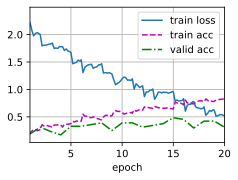

In [18]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()  # 每隔4个epoch之后，把当前学习率乘以0.9
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,lr_decay)

+ lr用的是，`2e-4`，就是$2\times 10^{-4}=0.0002$
+ wd用的是`5e-4`，就是$5\times 10^{-4}=0.0005$
+ lr_period, lr_decay, net = 4, 0.9, get_net()  表示每隔4个epoch之后，把当前学习率乘以0.9

In [19]:
2e-4 

0.0002

In [20]:
d2l.try_all_gpus()

[device(type='cuda', index=0)]

# 9. 预测并提交结果

train loss 0.635, train acc 0.766
262.2 examples/sec on [device(type='cuda', index=0)]


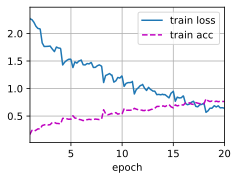

In [22]:
net, preds = get_net(), []
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,lr_decay)

for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid.classes[x])
df.to_csv('submission.csv', index=False)

可以看到，测试集上的准确率和之前训练的差不多
+ 那么如果是这种情况，那在打比赛的时候，其实就已经可以去上传东西了
+ 不过这里上传有点问题，没有使用测试文件的文件名序号，而是自己按照顺序生成了一下。。。就很诡异？？？
+ 看了一下网页中上传结果的要求，是要求按照序号从小到大的，可能原始比赛中，test集合序号就是从1开始的吧

# 10. 小结（使用一组新的参数来训练）

batch_size = 128，num_epochs = 100，lr = 0.1，lr_period = 50，lr_decay = 0.1

train loss 0.019, train acc 0.996, valid acc 0.609
252.3 examples/sec on [device(type='cuda', index=0)]


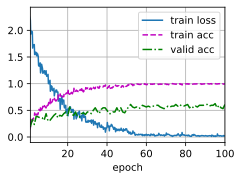

In [24]:
batch_size=128

devices, num_epochs, lr, wd = d2l.try_all_gpus(), 100, 0.0001, 5e-4
lr_period, lr_decay, net = 50,0.1, get_net() 
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,lr_decay)

如果设置`lr=0.1`，因为学习率过大，一直会在0附近盘旋，基本学不到东西，改成`1e-4`试试，训练就正常了很多

train loss 0.021, train acc 0.993
253.8 examples/sec on [device(type='cuda', index=0)]


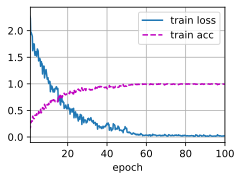

In [26]:
net, preds = get_net(), []
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,lr_decay)

for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid.classes[x])
df.to_csv('submission.csv', index=False)